## Paso 01 - Lectura del conjunto de información

In [1]:
# Importar las librerías de que nos ayudarán a obtener la información, organizarla y procesarla
import pandas as pd

In [22]:
# Lectura del archivo que contiene el corpus con la información clasificada
# y preprocesada (Ham VS Spam)
df = pd.read_csv("/home/kuautli/Documents/Python-Projects/apuntes-nlp/data/Spamless_DataSet.csv")
df.head(5)

# Referencia para la lectura de archivos en: https://codeday.me/es/qa/20190412/477724.html

,clase,mensaje
0,NoSpam,Acuerdo para la reunión de planeación
1,NoSpam,[IMPORTANTE] Cambio de hora en la cita de mañana
2,NoSpam,Envio de información solicitada
3,NoSpam,Problema de autenticación resuelto
4,NoSpam,Activación correcta de tu cuenta


## Paso 02 - Verificación y validación de la información

In [23]:
# Para detectar si tenemos filas vacías
print("Tamaño del data frame: " + str(len(df)))
print("Cantidad de filas vacías:")
print(df.isnull().sum())

# Eliminamos las filas vacías y vemos el tamaño del nuevo df
df = df.dropna()
df = df[df['mensaje'] != ""]
print("\nTamaño del data frame sin vacíos: " + str(len(df)))

Tamaño del data frame: 91
Cantidad de filas vacías:
clase      0
mensaje    3
dtype: int64

Tamaño del data frame sin vacíos: 88


In [24]:
# Verificar cuales son las clasificaciones que tenemos en nuestro DataSet
print("Clases que tenemos en el DataSet:")
print(df['clase'].unique())

# Revisamos la cantidad de ejemplos que tenemos por cada clase
print("\nCantidad de ejemplos que tenemos por clase:")
print(df['clase'].value_counts())

Clases que tenemos en el DataSet:
['NoSpam' 'Spam']

Cantidad de ejemplos que tenemos por clase:
clase
Spam      60
NoSpam    28
Name: count, dtype: int64


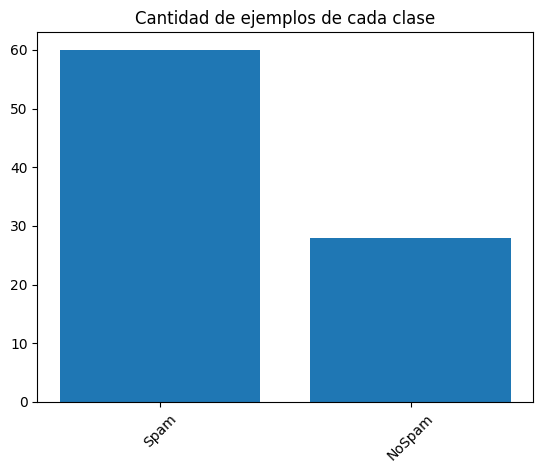

In [25]:
# Ploteamos la cantidad de ejemplos que tenemos de cada clase
# para ver si esta se encuentra balanceada o no
import matplotlib.pyplot as plt

Totales = df['clase'].value_counts()
plt.bar(['Spam', 'NoSpam'], Totales)
plt.xticks(rotation = 45)
plt.title('Cantidad de ejemplos de cada clase')
plt.show()

## Paso 04 - Buscar relaciones en la información

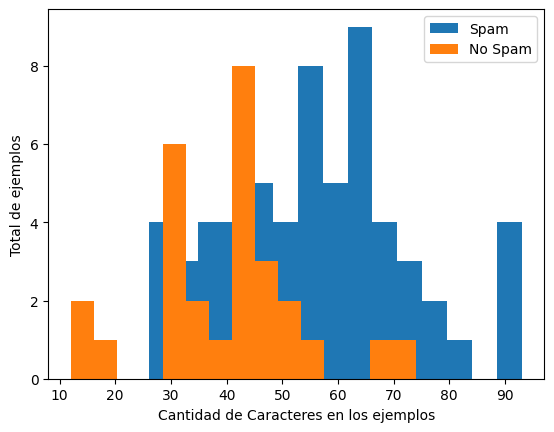

In [26]:
# Para analizar la información, ploteamos un histograma
# que nos indica la frecuencia de caracteres tanto en
# Ham como en Spam para revisar su comportamiento

Spams = []
NoSpams = []
for clase, mensaje in zip(df['clase'], df['mensaje']):
    if clase == 'Spam':
        Spams.append(len(mensaje))
    else:
        NoSpams.append(len(mensaje))


plt.hist(Spams, bins=15)
plt.hist(NoSpams, bins=15)
plt.legend(['Spam', 'No Spam'])
plt.xlabel('Cantidad de Caracteres en los ejemplos')
plt.ylabel('Total de ejemplos')
plt.show()

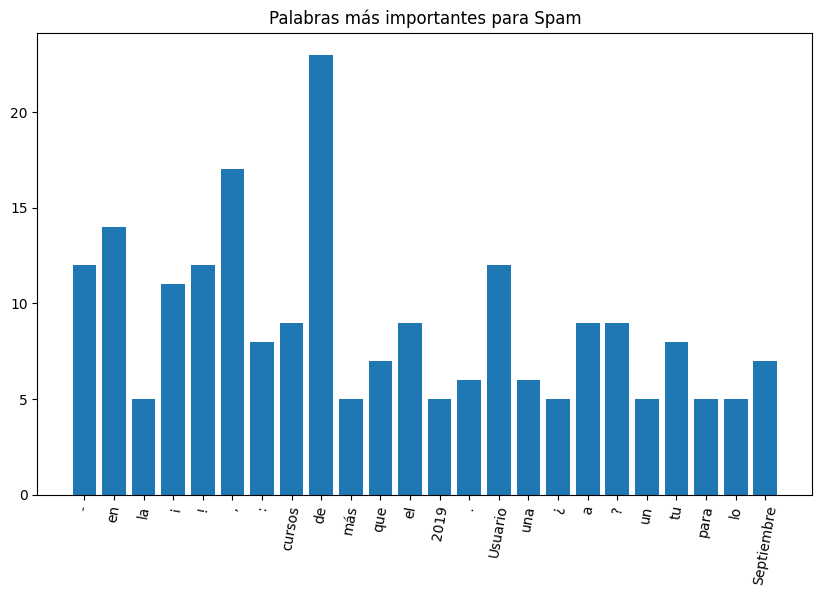

In [28]:
# Importamos el núcleo de trabajo para hacer la tokenización
import spacy

nlp_es = spacy.load('es_core_news_lg')

# Gráfica de los tokens más utilizados para Spam
Palabras_Spam = {}

for clase, mensaje in zip(df['clase'], df['mensaje']):
    if clase == 'Spam':
        for token in nlp_es(mensaje):
            if(Palabras_Spam.get(token.text) == None):
                Palabras_Spam.setdefault(token.text, 1)
            else:
                Palabras_Spam[token.text] += 1

Palabras_Spam2 = {}
for clave, valor in zip(Palabras_Spam.keys(), Palabras_Spam.values()):
    if(valor >= 5):
        Palabras_Spam2.setdefault(clave, valor)

plt.figure(figsize=(10,6))
plt.bar(Palabras_Spam2.keys(), Palabras_Spam2.values())
plt.title('Palabras más importantes para Spam')
plt.xticks(rotation=80)
plt.show()

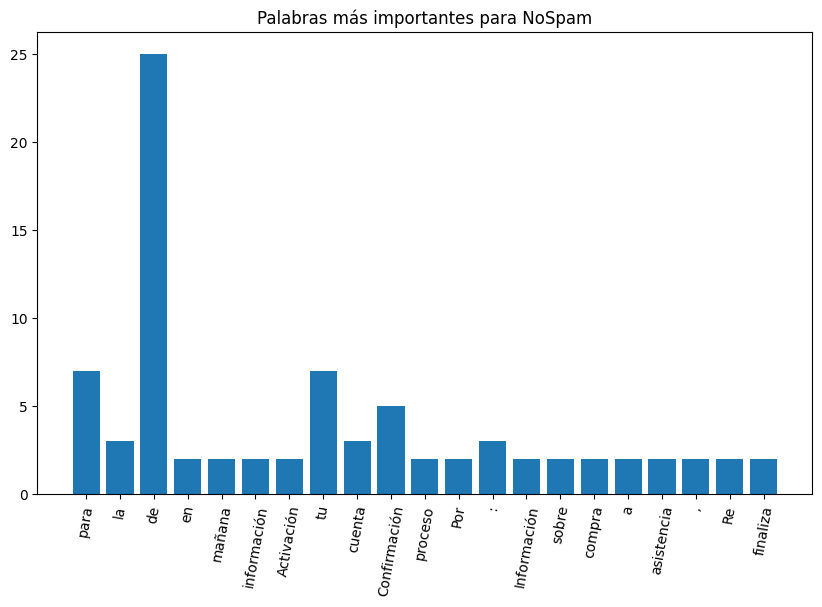

In [29]:
# Gráfica de los tokens más utilizados para No Spam
Palabras_NoSpam = {}

for clase, mensaje in zip(df['clase'], df['mensaje']):
    if clase == 'NoSpam':
        for token in nlp_es(mensaje):
            if(Palabras_NoSpam.get(token.text) == None):
                Palabras_NoSpam.setdefault(token.text, 1)
            else:
                Palabras_NoSpam[token.text] += 1

Palabras_NoSpam2 = {}
for clave, valor in zip(Palabras_NoSpam.keys(), Palabras_NoSpam.values()):
    if(valor >= 2):
        Palabras_NoSpam2.setdefault(clave, valor)

plt.figure(figsize=(10,6))
plt.bar(Palabras_NoSpam2.keys(), Palabras_NoSpam2.values())
plt.title('Palabras más importantes para NoSpam')
plt.xticks(rotation=80)
plt.show()

## Paso05 - Construcción del modelo de NLP

In [30]:
# Separar la información (Dataset) en conjuntos de entrenamiento y validación

# Importar la librería de Sklearn
from sklearn.model_selection import train_test_split

# Definimos nuestra información (Nombre de la clase (Y) y valor (X))
X = df['mensaje'] # Entrada (Información que tenemos)
Y = df['clase'] # Salidas (Respuestas deseadas para cada texto de entrada)

# Segmentamos la información en conjuntos de entrenamiento y de validación (80 / 20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [31]:
# Se importa la librería para extraccion de características y vectorización
# de los ejemplos usando la función CountVectorizer()
# (Permite conocer información de los daros de entrenamiento)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

#  Con esta línea se construye un diccionario (Vocabulario de palabras) y se
# cuenta el número de palabras que hay para cada elemento del diccionario
X_train_counts = count_vect.fit_transform(X_train)

# (Shape) El primer número representa los mensajes, y el segundo el vocabulario usado
X_train_counts.shape

(70, 306)

In [32]:
# Se crea un Pipeline para asignar la secuencia de procesos
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# En el Pipeline se mete en un arreglo la secuencia de pasos que se desea
# seguir, o elementos que se desea enviar, en este caso 1) Vector de Tf-idf
# 2) El modelo LinearSVC
# En esta línea se hace la vectorización y se ejecuta el clasificador en un solo paso
clasificador_Texto = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC())])

In [33]:
# Visualizamos los parámetros de nuestro modelo (De referencia)
print(clasificador_Texto.get_params().keys())

# Podemos cambiar algunos de los parámetros como por ejempplo, uso de minúsculas
# filtrado de stopwords y máximo de características a usar
clasificador_Texto.set_params(tfidf__lowercase=True, tfidf__stop_words=['de', 'para'], tfidf__max_features=None)

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__loss', 'clf__max_iter', 'clf__multi_class', 'clf__penalty', 'clf__random_state', 'clf__tol', 'clf__verbose'])


Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words=['de', 'para'])),
                ('clf', LinearSVC())])

In [34]:
clasificador_Texto.fit(X_train, Y_train) # Entrasas VS Salidas
Predicciones = clasificador_Texto.predict(X_test) # Usar conjunto de pruebas
print(X_test)
print(Predicciones)

3                    Problema de autenticación resuelto
67       Estreno el viernes 13 de Septiembre... Monarca
81                 ¡Atrévete a acelerar tu aprendizaje!
31           PRÓXIMAMENTE: cursos de francés más breves
1      [IMPORTANTE] Cambio de hora en la cita de mañana
9     Confirmación de Activación de Cuenta en App Móvil
50    Usuario: Te esperan hermosas playas e impresio...
71    Usuario, mira quien entró en la lista LinkedIn...
84    Vive y estudia en el Reino Unido - Study UK Fa...
77            Usuario: ¿ya es hora de hacer otro viaje?
44    Tenemos una nueva vacante de Ingeniería en el ...
69    Announcing 50,000 Bertelsmann Technology Schol...
89           Has aparecido en 10 búsquedas esta semanal
57                           ¡Las rebajas terminan hoy!
30    Auth0 Is A Gartner Visionary, Coding How-Tos, ...
88    No pierdas tu lugar - Curso Machine Learning P...
41    Nuevo precio para Candlewood Suites Anaheim - ...
72    Agrega una cuenta bancaria en PayPal antes

/home/kuautli/Documents/Python-Projects/apuntes-nlp/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [35]:
clasificador_Texto.predict(["Gracias por cofirmar tu asistencia",
                            "Hola usuario, tenemos una oferta para tí",
                            "Solo por hoy, el precio ha bajado",
                            "Esperamos que te encuentras bien, ya hemos hecho la activación de tu cuenta",
                            "Porqué no revisas estos ofertones??",
                            "Mantequilla"])

array(['NoSpam', 'Spam', 'Spam', 'NoSpam', 'Spam', 'Spam'], dtype=object)

## Matriz de confusión

In [36]:
# Matriz de confusión y Métricas de evaluación del modelo
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# Impresión de matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(Y_test, Predicciones))

# Impresión de procentaje de Accuracy del modelo
print("\nAccuracy del modelo: ")
print(metrics.accuracy_score(Y_test, Predicciones))

# Impresión de las métricas para el modelo
print("\nMétricas de evaluación:")
print(classification_report(Y_test, Predicciones))

Matriz de confusión:
[[ 2  1]
 [ 1 14]]

Accuracy del modelo: 
0.8888888888888888

Métricas de evaluación:
              precision    recall  f1-score   support

      NoSpam       0.67      0.67      0.67         3
        Spam       0.93      0.93      0.93        15

    accuracy                           0.89        18
   macro avg       0.80      0.80      0.80        18
weighted avg       0.89      0.89      0.89        18

